# Data Playground
#### M Chu
Collection of ideas; serves as a running, semi-organized progress report.

Will consolidate, reorganize & streamline the codes once we find out what works and what doesn't / decide on which direction we will be focusing on.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import timeit

#%matplotlib inline
import matplotlib.pyplot as plt

## Importing data

More rows than columns; not good. Collecting a more tick data of the same stocks is trivial, but for now we'll work with this dataset.

In [2]:
raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')
log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
# drop first row of raw prices so it has the same dimensions as the log-returns DF
raw_asset_prices_df = raw_asset_prices_df.iloc[1:]

df_shape = (raw_asset_prices_df.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

raw_asset_prices_df.head()

There are 251 rows and 504 columns in the dataset.
Data timeperiod covers: 2020/6/22 to 2021/6/18


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2020/6/22,89.717499,200.570007,2713.820068,239.220001,1450.660034,1451.859985,96.750000,198.863998,143.389999,292.670013,...,16.41,11.81,55.180000,73.339996,27.600000,21.840000,31.730000,9.51,8.58,11.99
2020/6/23,91.632500,201.910004,2764.409912,242.240006,1463.979980,1464.410034,97.930000,200.356003,142.860001,297.600006,...,16.42,12.13,55.070000,73.459999,27.809999,22.160000,31.480000,9.86,8.93,12.07
2020/6/24,90.014999,197.839996,2734.399902,234.020004,1432.699951,1431.969971,94.660004,192.169998,139.820007,289.179993,...,15.51,11.19,53.950001,70.650002,27.010000,21.719999,29.580000,9.47,8.58,11.69
2020/6/25,91.209999,200.339996,2754.580078,235.679993,1441.099976,1441.329956,97.959999,197.195999,139.669998,296.220001,...,16.35,12.29,54.730000,70.320000,26.750000,21.260000,29.639999,9.60,8.67,11.77
2020/6/26,88.407501,196.330002,2692.870117,216.080002,1362.540039,1359.900024,92.589996,191.947998,137.809998,286.880005,...,15.52,12.19,53.939999,67.699997,25.750000,20.260000,28.209999,9.11,8.26,11.54


In [3]:
log_returns_df.head()

,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2020/6/22,0.025827,0.027395,0.014404,0.001799,0.018099,0.013969,-0.010896,-0.006596,-0.003064,0.004898,...,-0.004257,0.005945,0.005634,0.026948,-0.007939,-0.014094,-0.015945,0.000000,-0.002328,0.009217
2020/6/23,0.021120,0.006659,0.018470,0.012545,0.009140,0.008607,0.012123,0.007475,-0.003703,0.016705,...,0.000609,0.026735,-0.001995,0.001635,0.007580,0.014546,-0.007910,0.036142,0.039983,0.006650
2020/6/24,-0.017810,-0.020363,-0.010915,-0.034522,-0.021598,-0.022401,-0.033961,-0.041715,-0.021509,-0.028701,...,-0.057015,-0.080661,-0.020547,-0.039003,-0.029188,-0.020055,-0.062254,-0.040357,-0.039983,-0.031989
2020/6/25,0.013188,0.012557,0.007353,0.007068,0.005846,0.006515,0.034268,0.025818,-0.001073,0.024053,...,0.052743,0.093765,0.014354,-0.004682,-0.009673,-0.021406,0.002026,0.013634,0.010435,0.006820
2020/6/26,-0.031208,-0.020219,-0.022657,-0.086826,-0.056056,-0.058155,-0.056378,-0.026974,-0.013407,-0.032038,...,-0.052098,-0.008170,-0.014540,-0.037970,-0.038100,-0.048179,-0.049448,-0.052390,-0.048444,-0.019735


## Construction of correlation matrix
Sample correlation matrix is very ill-conditioned. Will need shrinkages and other robust estimates (ad-hoc or otherwise) to improve the corr.

Sample corr. had a condition number of ~$10^{19}$. With ad-hoc shrinkage (shrinkage target: $I_n$), cond number is ~$10^6$. Can further improve by considering other robust estimates of corr.

Might as well wrap the whole shrinkage pipeline into a function as we will backtest (and re-compute the corr. on daily ticks), but for now this will do.

In [4]:
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
#shr_target=np.ones((df_shape[1], df_shape[1]))
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 1.13e+19
Condition number of shrunk correlation matrix: 1.49e+06


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
AAPL,1.000000,0.694200,0.691205,0.634493,0.522702,0.512583,0.029423,0.492938,0.220624,0.205805,...,0.025386,-0.016511,0.115755,-0.015630,0.113051,0.024639,0.014589,-0.048178,-0.046476,0.174052
MSFT,0.694200,1.000000,0.741015,0.608564,0.717165,0.705709,0.040791,0.500559,0.284647,0.324833,...,-0.011969,-0.025407,0.099012,-0.058433,0.072387,-0.047254,-0.014123,-0.063651,-0.067568,0.198791
AMZN,0.691205,0.741015,1.000000,0.688021,0.622603,0.626005,-0.070769,0.478916,0.109943,0.217174,...,-0.123943,-0.089610,-0.038883,-0.092398,0.002334,-0.070554,-0.108014,-0.055348,-0.060529,0.113214
FB,0.634493,0.608564,0.688021,1.000000,0.658567,0.657867,0.020714,0.349706,0.187031,0.319269,...,-0.031311,-0.046235,0.007846,-0.037580,0.074092,0.007478,-0.002316,0.010992,0.011035,0.176672
GOOGL,0.522702,0.717165,0.622603,0.658567,1.000000,0.993162,0.189587,0.377768,0.281600,0.377338,...,0.127267,0.168430,0.140180,0.083248,0.154922,0.043158,0.147497,0.181127,0.186247,0.266149


## Graph construction and centrality/peripherality measures
Interestingly, from Pozzi et al., they used different edge weights for each centrality/peripherality meaures.

Pipeline:

1. Construct correlation matrix (for each tick, say, daily data)
    * Robust est. and shrinkage sorely needed
2. preprocess corr. as adjacency matrix 
    * $R_{ij} \mapsto 1+R_{ij}$ for Deg and Eig-Centrality
    * $R_{ij} \mapsto \sqrt{2(1-R_{ij})}$ for BC, Closeness, and Eccentricity
3. port to graph then construct MST/PMFG.etc
4. report centrality/peripherality measures for each node
    * Betweeness-centrality, eccentricity .etc
5. Aggregate the measures; analyze and compose hybrid cen/per index



In [5]:
# edges are weighted
Gt1 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
print(nx.info(Gt1))

print('Sanity check: edge weights are non-binary...')
nx.adjacency_matrix(Gt1)[0,1]

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 126756
Average degree: 503.0000
Sanity check: edge weights are non-binary...


0.694200351385983

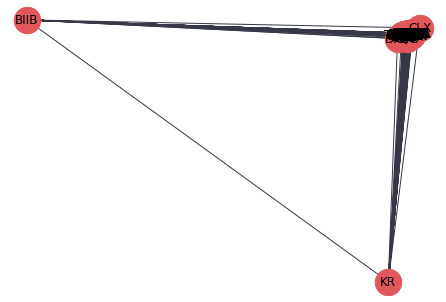

In [6]:
nx.draw(Gt1, with_labels=True, node_size=700, node_color="#e1575c",
        edge_color='#363847',  pos=nx.spectral_layout(Gt1))

In [7]:
# spectral layout takes time to compute (~5secs)
# G0 is simple (i.e. binary edge weights)
# spec layout non determinsitic?
# Gt1 highly clustered on just one stock
# or maybe algo just broke cuz neg weights

In [8]:
Gt1_mst = nx.minimum_spanning_tree(Gt1)
print(nx.info(Gt1_mst))

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 503
Average degree:   1.9960


Centrality/peripherality measures: 
* degree 
* betweenness-centrality
* eccentricity
* closeness
* eigenvector-centrality

In [9]:
print('Testing runtime for graph operations:\n')

print('\nMST construction from correlation')
%timeit nx.minimum_spanning_tree(Gt1)
print('\nDegree')
%timeit nx.degree(Gt1_mst)
print('\nBetweenness Centrality')
%timeit nx.betweenness_centrality(Gt1_mst)
print('\nEccentricity')
%timeit nx.eccentricity(Gt1_mst)
print('\nCloseness')
%timeit nx.closeness_centrality(Gt1_mst)
print('\nEigenvector Centrality')
%timeit nx.eigenvector_centrality(Gt1_mst)

Testing runtime for graph operations:


MST construction from correlation
290 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Degree
984 ns ± 33.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Betweenness Centrality
638 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eccentricity
218 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Closeness
220 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eigenvector Centrality
55.9 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# need to preprocess the corr mat before MST-ing them (ad-hoc mapping to euclidean/similarity measures)
# notably, measures require different corr-preprocessing before casting it into a simple graph by MST/PMFG
# (so their resultant graphs are not necessarily the same)

deg= pd.DataFrame.from_dict(dict(Gt1_mst.degree), orient='index', columns = ['D'])
BC = pd.DataFrame.from_dict(nx.betweenness_centrality(Gt1_mst), orient='index', columns = ['BC'])
ecc= pd.DataFrame.from_dict(nx.eccentricity(Gt1_mst), orient='index', columns = ['E'])
clo= pd.DataFrame.from_dict(nx.closeness_centrality(Gt1_mst), orient='index', columns = ['C'])
EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(Gt1_mst), orient='index', columns = ['EC'])

centralities_names = ['BC', 'C', 'D', 'E', 'EC']

centralities = deg
centralities['BC'] = BC
centralities['E']  = ecc
centralities['C']  = clo
centralities['EC'] = EC
print(centralities.head())

       D   BC   E         C            EC
AAPL   1  0.0  11  0.192868  2.913558e-05
MSFT   1  0.0  11  0.192868  2.913558e-05
AMZN   1  0.0  11  0.192868  2.913558e-05
FB     1  0.0   9  0.221977  4.355697e-03
GOOGL  1  0.0  14  0.111530  1.602348e-07


In [11]:
centralities.corr()

,D,BC,E,C,EC
D,1.000000,0.764840,-0.065831,0.135179,0.698694
BC,0.764840,1.000000,-0.099506,0.194557,0.485889
E,-0.065831,-0.099506,1.000000,-0.950289,-0.530921
C,0.135179,0.194557,-0.950289,1.000000,0.642150
EC,0.698694,0.485889,-0.530921,0.642150,1.000000


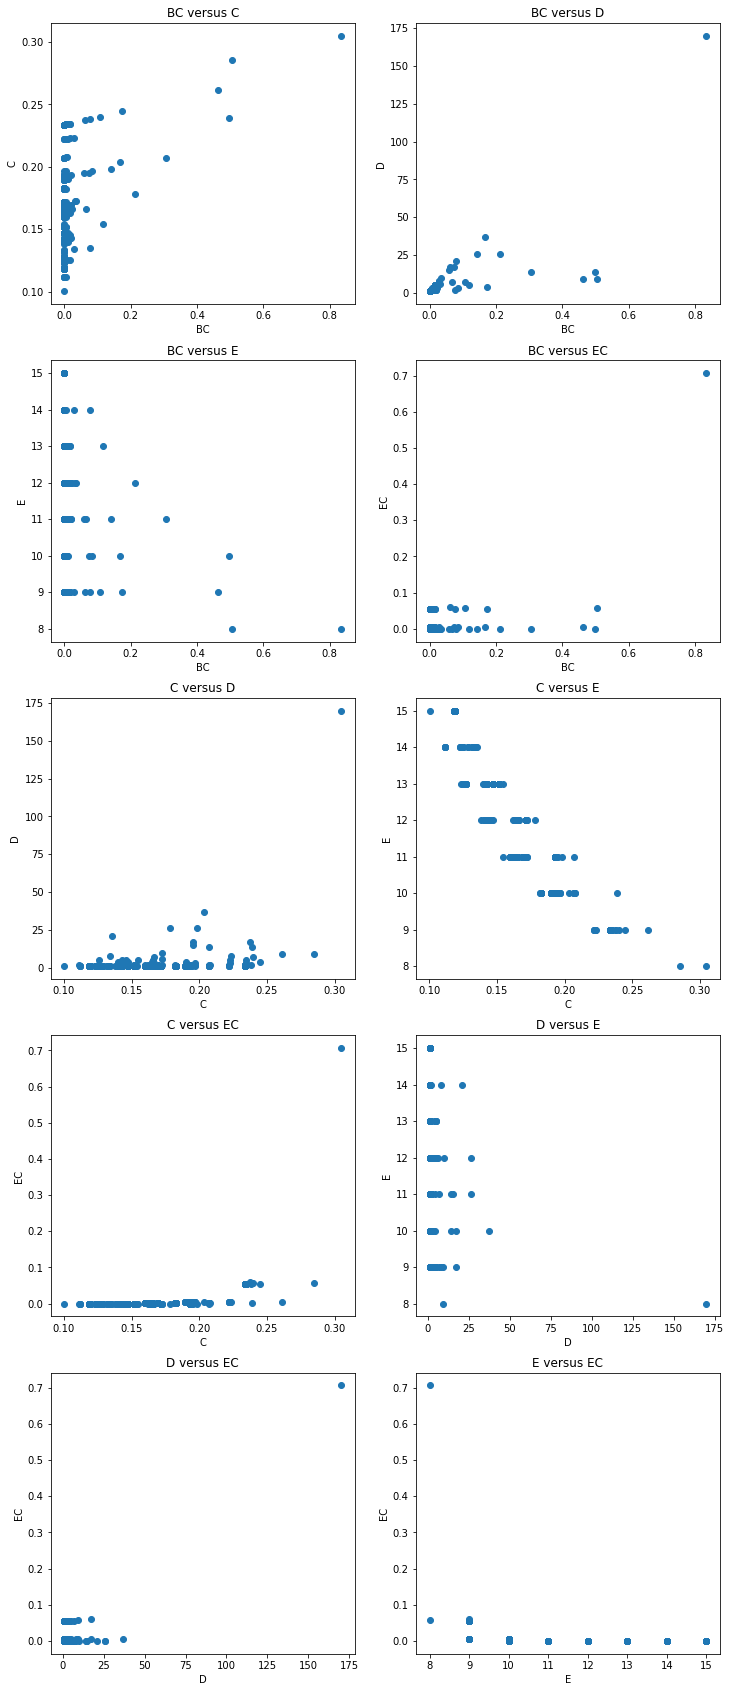

In [12]:
from itertools import combinations

plot_len = 6
plt.figure(figsize=(plot_len*2, plot_len*5))

i=1
for x,y in combinations(centralities_names, 2):
    plt.subplot(5, 2, i)      #5C2 = 10
    plt.scatter(centralities[x], centralities[y])
    plt.title(x+' versus '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    i+=1

In [13]:
for cen_measure in centralities_names:
    print(cen_measure + ': ' + centralities[cen_measure].idxmax())

BC: CLX
C: CLX
D: CLX
E: CSCO
EC: CLX


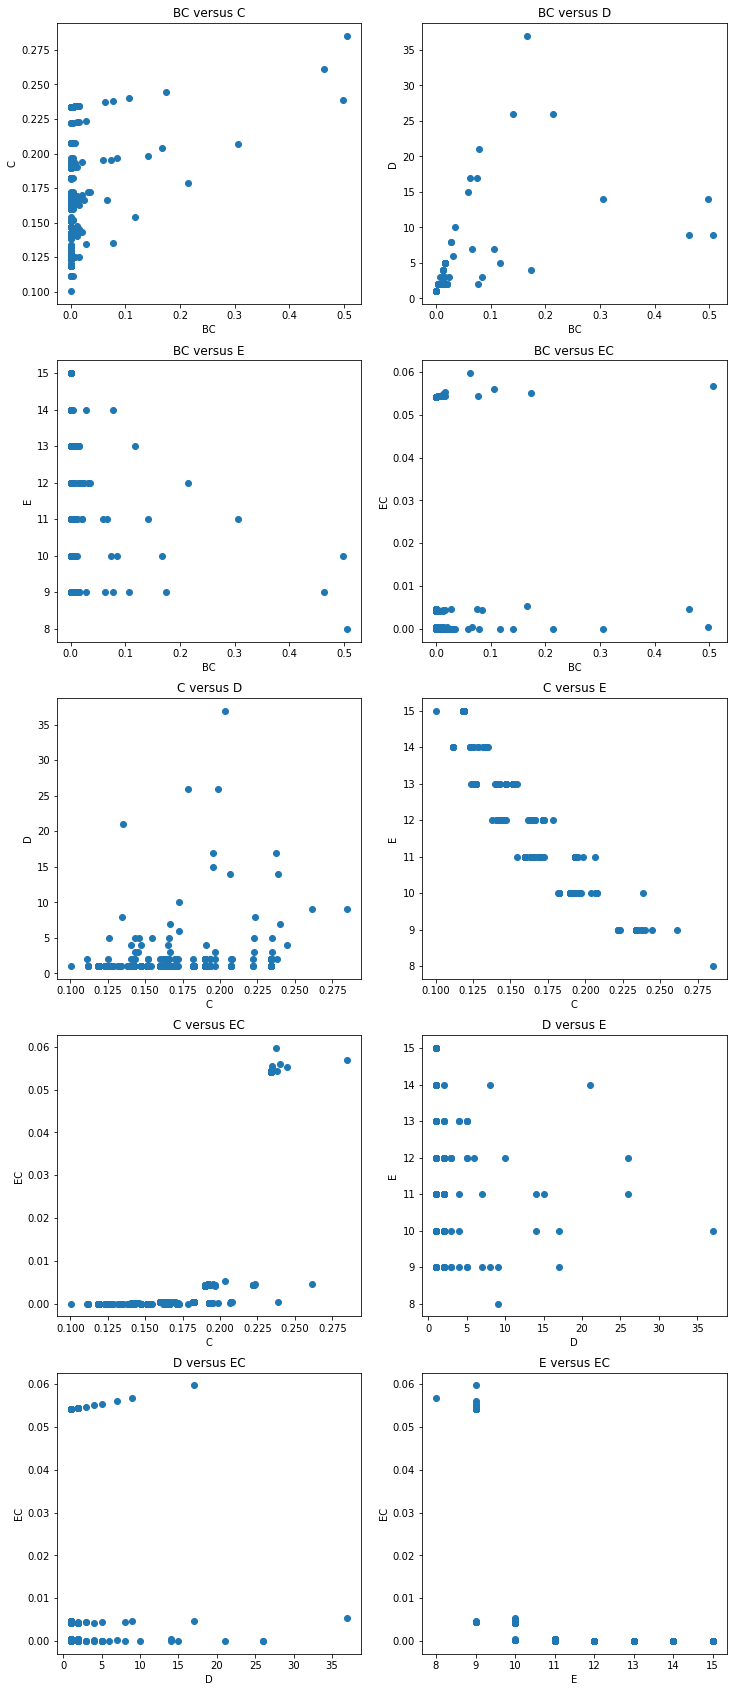

In [14]:
# plot, but remove the outlier (i.e. root node)
plot_len = 6
plt.figure(figsize=(plot_len*2, plot_len*5))

cen_noout = centralities.drop(['CLX'])
i=1
for x,y in combinations(centralities_names, 2):
    plt.subplot(5, 2, i)
    plt.scatter(cen_noout[x], cen_noout[y])
    plt.title(x+' versus '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    i+=1

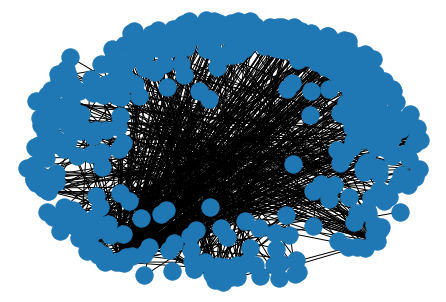

In [15]:
nx.draw(Gt1_mst, pos=nx.fruchterman_reingold_layout(Gt1_mst))